<a href="https://colab.research.google.com/github/zmgy107/DGL-Learning-Notes/blob/main/Chapter_5_Training_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install  dgl -f https://data.dgl.ai/wheels/cu117/repo.html
%pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

import dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu117/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 MB 3.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Here we take a synthetic heterogeneous graph as an example for demonstrating node classification, edge classification, and link prediction tasks.

The synthetic heterogeneous graph hetero_graph has these edge types:

*  ('user', 'follow', 'user')

*  ('user', 'followed-by', 'user')

*  ('user', 'click', 'item')

*  ('item', 'clicked-by', 'user')

*  ('user', 'dislike', 'item')

*  ('item', 'disliked-by', 'user')

In [3]:
import numpy as np
import torch

n_users=1000
n_items=500
n_follows=3000
n_clicks=5000
n_dislikes=500
n_hetero_features=10
n_user_classes=5
n_max_clicks=10

follow_src=np.random.randint(0,n_users,n_follows)
follow_dst=np.random.randint(0,n_users,n_follows)
click_src=np.random.randint(0,n_users,n_clicks)
click_dst = np.random.randint(0, n_items, n_clicks)
dislike_src = np.random.randint(0, n_users, n_dislikes)
dislike_dst = np.random.randint(0, n_items, n_dislikes)

hetero_graph=dgl.heterograph({
    ('user','follow','user'):(follow_src,follow_dst),
    ('user','followed-by','user'):(follow_dst,follow_src),
    ('user','click','item'):(click_src,click_dst),
    ('item', 'clicked-by', 'user'): (click_dst, click_src),
    ('user', 'dislike', 'item'): (dislike_src, dislike_dst),
    ('item', 'disliked-by', 'user'): (dislike_dst, dislike_src)})

hetero_graph.nodes['user'].data['feature']=torch.randn(n_users,n_hetero_features)
hetero_graph.nodes['item'].data['feature'] = torch.randn(n_items, n_hetero_features)
hetero_graph.nodes['user'].data['label'] = torch.randint(0, n_user_classes, (n_users,))
hetero_graph.edges['click'].data['label'] = torch.randint(1, n_max_clicks, (n_clicks,)).float()
# randomly generate training masks on user nodes and click edges
hetero_graph.nodes['user'].data['train_mask']=torch.zeros(n_users,dtype=torch.bool).bernoulli(0.6)
hetero_graph.edges['click'].data['train_mask'] = torch.zeros(n_clicks, dtype=torch.bool).bernoulli(0.6)

# 5.1 Node Classification/Regression

To classify nodes, graph neural network performs message passing discussed in Chapter 2: Message Passing to utilize the node’s own features, but also its neighboring node and edge features. Message passing can be repeated multiple rounds to incorporate information from larger range of neighborhood.

## Writing neural network model

choose dgl.nn.pytorch.SAGEConv as an example of built-in graph convolution modules that can perform one round of message passing.

Usually for deep learning models on graphs we need a multi-layer graph neural network, where we do multiple rounds of message passing. This can be achieved by stacking graph convolution modules as follows.

In [ ]:
from torch._C import AggregationType
# contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
  def __init__(self,in_feats,hid_feats,out_feats):
    super().__init__()
    self.conv1=dglnn.SAGEConv(
        in_feats=in_feats,out_feats=hid_feats,aggregator_type='mean')
    self.conv2=dglnn.SAGEConv(
        in_feats=hid_feats,out_feats=out_feats,aggregator_type='mean')
  
  def forward(self,graph,inputs):
    # inputs are features of nodes
    h=self.conv1(graph,inputs)
    h=F.relu(h)
    h=self.conv2(graph,h)
    return h

__Note that you can use the model above for not only node classification, but also obtaining hidden node representations for other downstream tasks__ such as edge classification/regression,link prediction,or graph classification

## Training loop

Training on the full graph simply involves a forward propagation of the model defined above, and computing the loss by comparing the prediction against ground truth labels on the training nodes.

We use dgl.data.CiteseerGraphDataset to show a training loop below. The node features and labels are stored on its graph instance, and the training-validation-test split are also stored on the graph as boolean masks.

In [ ]:
#node_features = graph.ndata['feat']
#node_labels = graph.ndata['label']
#train_mask = graph.ndata['train_mask']
#valid_mask = graph.ndata['val_mask']
#test_mask = graph.ndata['test_mask']
#n_features = node_features.shape[1]
#n_labels = int(node_labels.max().item() + 1)

In [ ]:
# example of evaluating your model by accuracy.
def evaluate(model,graph,features,labels,mask):
  model.eval()
  with torch.no_grad():
    logits=model(graph,features)
    logits=logits[mask]
    labels=labels[mask]
    _,indices=torch.sum(indices==labels)
    return correct.item()*1.0/len(labels)

# a training loop as follows
model= SAGE(in_feats=n_features,hid_feats=100,out_feats=n_labels)
opt=torch.optim.Adam(model.parameters())

for epoch in range(10):
  model.train()
  # forward propagation by using all nodes
  logits=model(graph,node_features)
  # compute loss
  loss=F.cross_entropy(logits[train_mask],node_labels[train_mask])
  # compute validation accuracy
  acc=evaluate(model,graph,node_features,node_labels,valid_mask)
  # backward propagation
  opt.zero_grad()
  loss.backward()
  opt.step()
  print(loss.item())

  # save model if necessary,omitted in this example

## Heterogeneous graph

If your graph is heterogeneous, you may want to gather message from neighbors along all edge types. You can use the module dgl.nn.pytorch.HeteroGraphConv (also available in MXNet and Tensorflow) to perform message passing on all edge types, then combining different graph convolution modules for each edge type.

The following code will define a heterogeneous graph convolution module that __first performs a separate graph convolution on each edge type, then sums the message aggregations on each edge type as the final result for all node types.__

In [ ]:
# Define a Heterograph Conv model

class RGCN(nn.Module):
  def __init__(self,in_feats,hid_feats,out_feats,rel_names):
    super().__init__()

    self.conv1=dglnn.HeterGraphConv({
        rel:dglnn.GrapgConv(in_feats,hid_feats)
        for rel in rel_names},aggregate='sum')
    self.conv2=dglnn.GraphConv({
        rel:dglnn.GraphConv(hid_feats,out_feats)
        for rel in rel_names},aggregate='sum')
    
  def forward(self,graph,inputs):
    # input are features of nodes
    h=self.conv1(graph,inputs)
    h={k:F.relu(v) for k,v in h.items()}
    h=self.conv2(graph,h)
    return h

#dgl.nn.HeteroGraphConv takes in a dictionary of node types 
#and node feature tensors as input, and returns another 
#dictionary of node types and node features.

model=RGCN(n_hetero_features,20,n_user_classes,hetero_graph.etypes)
user_feats=hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
labels = hetero_graph.nodes['user'].data['label']
train_mask = hetero_graph.nodes['user'].data['train_mask']

One can simply perform a forward propagation as follows:

In [ ]:
node_features={'user':user_feats,'item':item_feats}
h_dict=model(hetero_graph,{'user':user_feats,'item':item_feats})
h_user=h_dict['user']
h_item=h_dict['item']

Training loop is the same as the one for homogeneous graph, except that now you have a dictionary of node representations from which you compute the predictions. For instance, if you are only predicting the user nodes, you can just extract the user node embeddings from the returned dictionary:

In [ ]:
opt = torch.optim.Adam(model.parameters())

for epoch in range(5):
    model.train()
    # forward propagation by using all nodes and extracting the user embeddings
    logits = model(hetero_graph, node_features)['user']
    # compute loss
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    # Compute validation accuracy.  Omitted in this example.
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

    # Save model if necessary.  Omitted in the example.

# 5.2 Edge Classification/Regression

Sometimes you wish __to predict the attributes on the edges of the graph.__ In that case, you would like to have an edge classification/regression model.

Here we generate a random graph for edge prediction as a demonstration.

In [ ]:
src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
edge_pred_graph.edata['feature'] = torch.randn(1000, 10)
edge_pred_graph.edata['label'] = torch.randn(1000)
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

From the previous section you have learned how to do node classification with a multilayer GNN. The same technique can be applied for computing a hidden representation of any node. The prediction on edges can then be derived from the representation of their incident nodes.

The most common case of computing the prediction on an edge is to __express it as a parameterized function of the representation of its incident nodes__, and optionally the features on the edge itself.

## Model Implementation Difference from Node Classification

Assuming that you compute the node representation with the model from the previous section, you only need to write another component that computes the edge prediction with the apply_edges() method.

For instance, if you would like to compute a score for each edge for edge regression, the following code computes the dot product of incident node representations on each edge.

In [ ]:
import dgl.function as fn
class DotProductPredictor(nn.Module):
  def forward(self,graph,h):
    # h contains the node representations computed from the GNN defined
    # in the node classification section (Section 5.1).
    with graph.local_scope():
      graph.ndata['h']=h
      graph.apply_edges(fn.u_dot_v('h','h','score'))
      return graph.edata['score']

One can also write a prediction function that predicts a vector for each edge with an MLP. Such vector can be used in further downstream tasks, e.g. as logits of a categorical distribution.

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

## Training loop

Given the node representation computation model and an edge predictor model, we can easily write a full-graph training loop where we compute the prediction on all edges.

The following example takes SAGE in the previous section as the node representation computation model and DotPredictor as an edge predictor model.

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

# assume that the training/validation/test edge sets
#are identified by boolean masks on edges

node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(10, 20, 5)
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    pred = model(edge_pred_graph, node_features)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

## Heterogeneous graph

Edge classification on heterogeneous graphs is not very different from that on homogeneous graphs. If you wish to perform edge classification on one edge type, you only need to compute the node representation for all node types, and predict on that edge type with apply_edges() method.

For example, to make DotProductPredictor work on one edge type of a heterogeneous graph, you only need to specify the edge type in apply_edges method.

In [ ]:
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

# similaryly write a HeteroMLPPredictor
class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edges[etype].data['score']

The end-to-end model that predicts a score for each edge on a single edge type will look like this:

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, x, etype):
        h = self.sage(g, x)
        return self.pred(g, h, etype)

Using the model simply involves feeding the model a dictionary of node types and features.

In [ ]:
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
label = hetero_graph.edges['click'].data['label']
train_mask = hetero_graph.edges['click'].data['train_mask']
node_features = {'user': user_feats, 'item': item_feats}

Then the training loop looks almost the same as that in homogeneous graph. For instance, if you wish to predict the edge labels on edge type click, then you can simply do

In [ ]:
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    pred = model(hetero_graph, node_features, 'click')
    loss = ((pred[train_mask] - label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

## Predicting Edge Type of an Existing Edge on a Heterogeneous Graph

Sometimes you may want to predict which type an existing edge belongs to.

This is a simplified version of rating prediction, which is common in recommendation literature.

You can use a heterogeneous graph convolution network to obtain the node representations.

To predict the type of an edge, you can simply repurpose the HeteroDotProductPredictor above so that it takes in another graph with only one edge type that “merges” all the edge types to be predicted, and emits the score of each type for every edge.

In the example here, you will need a graph that has two node types user and item, and one single edge type that “merges” all the edge types from user and item, i.e. click and dislike. This can be conveniently created using the following syntax:

In [ ]:
dec_graph=hetero_graph['user',:,'item']

which returns a heterogeneous graphs with node type user and item, as well as a single edge type combining all edge types in between, i.e. click and dislike.

Since the statement above also returns the original edge types as a feature named dgl.ETYPE, we can use that as labels.

In [ ]:
edge_label = dec_graph.edata[dgl.ETYPE]

Given the graph above as input to the edge type predictor module, you can write your predictor module as follows.

In [ ]:
class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__()
        self.W = nn.Linear(in_dims * 2, n_classes)

    def apply_edges(self, edges):
        x = torch.cat([edges.src['h'], edges.dst['h']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

The model that combines the node representation module and the edge type predictor module is the following:

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroMLPPredictor(out_features, len(rel_names))
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
        return self.pred(dec_graph, h)

# The training loop then simply be the following:
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
node_features = {'user': user_feats, 'item': item_feats}

opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    logits = model(hetero_graph, node_features, dec_graph)
    loss = F.cross_entropy(logits, edge_label)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

# 5.3 Link Prediction

In some other settings you may want to predict whether an edge exists between two given nodes or not. Such task is called a link prediction task.

A GNN-based link prediction model represents the likelihood of connectivity between two nodes $u$ and $v$ as a fucntion of $h_u^{(L)}$ and $h_v^{(L)}$,their node representation computed from the multi-layer GNN.

$$y_{u,v}=\phi(h_u^{(L)},h_V^{(L)}$$

In this section we refer to $y_{u,v}$ the score between node u and node v.

__Training a link prediction model involves comparing the scores between nodes connected by an edge against the scores between an arbitrary pair of nodes.__For example, given an edge connecting $u$ and $v$,we encourage the score between node $u$ and $v$ to be higher than the score between node $u$ and a sampled node $v'$ from an arbitrary _noise_ distribution $v'\sim P_n(v)$.Such methodology is called __negative sampling.__

There are lots of loss functions that can achieve the behavior above if minimized. A non-exhaustive list include:cross-entropy loss, BPR loss,Margin loss etc.

The neural network model to compute the score between u and v is identical to the edge regression model described above.

Here is an example of using dot product to compute the scores on edges.

In [ ]:
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

## Training loop

Because our score prediction model operates on graphs, we need to express the negative examples as another graph. The graph will contain all negative node pairs as edges.

The following shows an example of expressing negative examples as a graph. Each edge $(u,v)$ gets $k$ negative examples $(u,v_i)$ where $v_i$ is sampled from a uniform distribution.

In [ ]:
def construct_negative_graph(graph, k):
    src, dst = graph.edges()

    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.num_nodes(), (len(src) * k,))
    return dgl.graph((neg_src, neg_dst), num_nodes=graph.num_nodes())

The model that predicts edge scores is the same as that of edge classification/regression.

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, neg_g, x):
        h = self.sage(g, x)
        return self.pred(g, h), self.pred(neg_g, h)

The training loop then repeatedly constructs the negative graph and computes loss.

In [ ]:
def compute_loss(pos_score, neg_score):
    # Margin loss
    n_edges = pos_score.shape[0]
    return (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()

node_features = graph.ndata['feat']
n_features = node_features.shape[1]
k = 5
model = Model(n_features, 100, 100)
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    negative_graph = construct_negative_graph(graph, k)
    pos_score, neg_score = model(graph, negative_graph, node_features)
    loss = compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

#After training, the node representation can be obtained via

node_embeddings = model.sage(graph, node_features)

There are multiple ways of using the node embeddings. Examples include training downstream classifiers, or doing nearest neighbor search or maximum inner product search for relevant entity recommendation.

## Heterogeneous graphs

Link prediction on heterogeneous graphs is not very different from that on homogeneous graphs. The following assumes that we are predicting on one edge type, and it is easy to extend it to multiple edge types.

For example, you can reuse the HeteroDotProductPredictor above for computing the scores of the edges of an edge type for link prediction.

In [ ]:
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h contains the node representations for each node type computed from
        # the GNN defined in the previous section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

To perform negative sampling, one can construct a negative graph for the edge type you are performing link prediction on as well.

In [ ]:
def construct_negative_graph(graph, k, etype):
    utype, _, vtype = etype
    src, dst = graph.edges(etype=etype)
    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.num_nodes(vtype), (len(src) * k,))
    return dgl.heterograph(
        {etype: (neg_src, neg_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

The model is a bit different from that in edge classification on heterogeneous graphs since you need to specify edge type where you perform link prediction.

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, neg_g, x, etype):
        h = self.sage(g, x)
        return self.pred(g, h, etype), self.pred(neg_g, h, etype)

The training loop is similar to that of homogeneous graphs.

In [ ]:
def compute_loss(pos_score, neg_score):
    # Margin loss
    n_edges = pos_score.shape[0]
    return (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()

k = 5
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
node_features = {'user': user_feats, 'item': item_feats}
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    negative_graph = construct_negative_graph(hetero_graph, k, ('user', 'click', 'item'))
    pos_score, neg_score = model(hetero_graph, negative_graph, node_features, ('user', 'click', 'item'))
    loss = compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

# 5.4 Graph Classification

Instead of a big single graph, sometimes one might have the data in the form of multiple graphs, for example a list of different types of communities of people. By characterizing the friendship among people in the same community by a graph, one can get a list of graphs to classify. In this scenario, a graph classification model could help identify the type of the community, i.e. to classify each graph based on the structure and overall information.

## Overview

The major difference between graph classification and node classification or link prediction is that the prediction result characterizes the property of the entire input graph. One can perform the message passing over nodes/edges just like the previous tasks, but also needs to retrieve a graph-level representation.

The graph classification pipeline proceeds as follows:
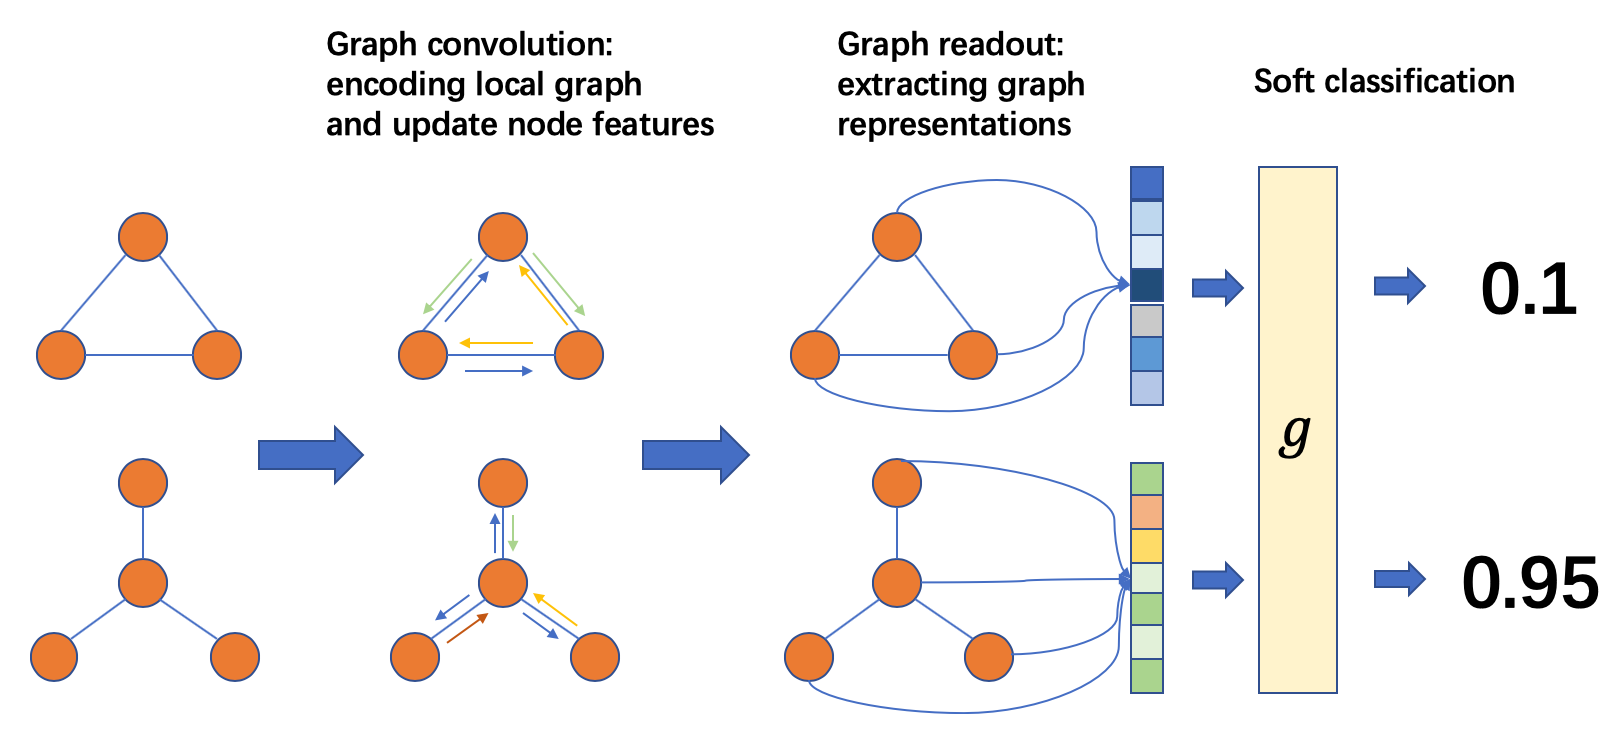

From left to right, the common practice is:

*  Prepare a batch of graphs
*  Perform message passing on the batched graphs to update node/edge features
*  Aggregate node/edge features into graph-level representations
*  Classify graphs based on graph-level representations

### Batch of Graphs

Usually a graph classification task trains on a lot of graphs, and it will be very inefficient to use only one graph at a time when training the model. Borrowing the idea of mini-batch training from common deep learning practice, one can build a batch of multiple graphs and send them together for one training iteration.

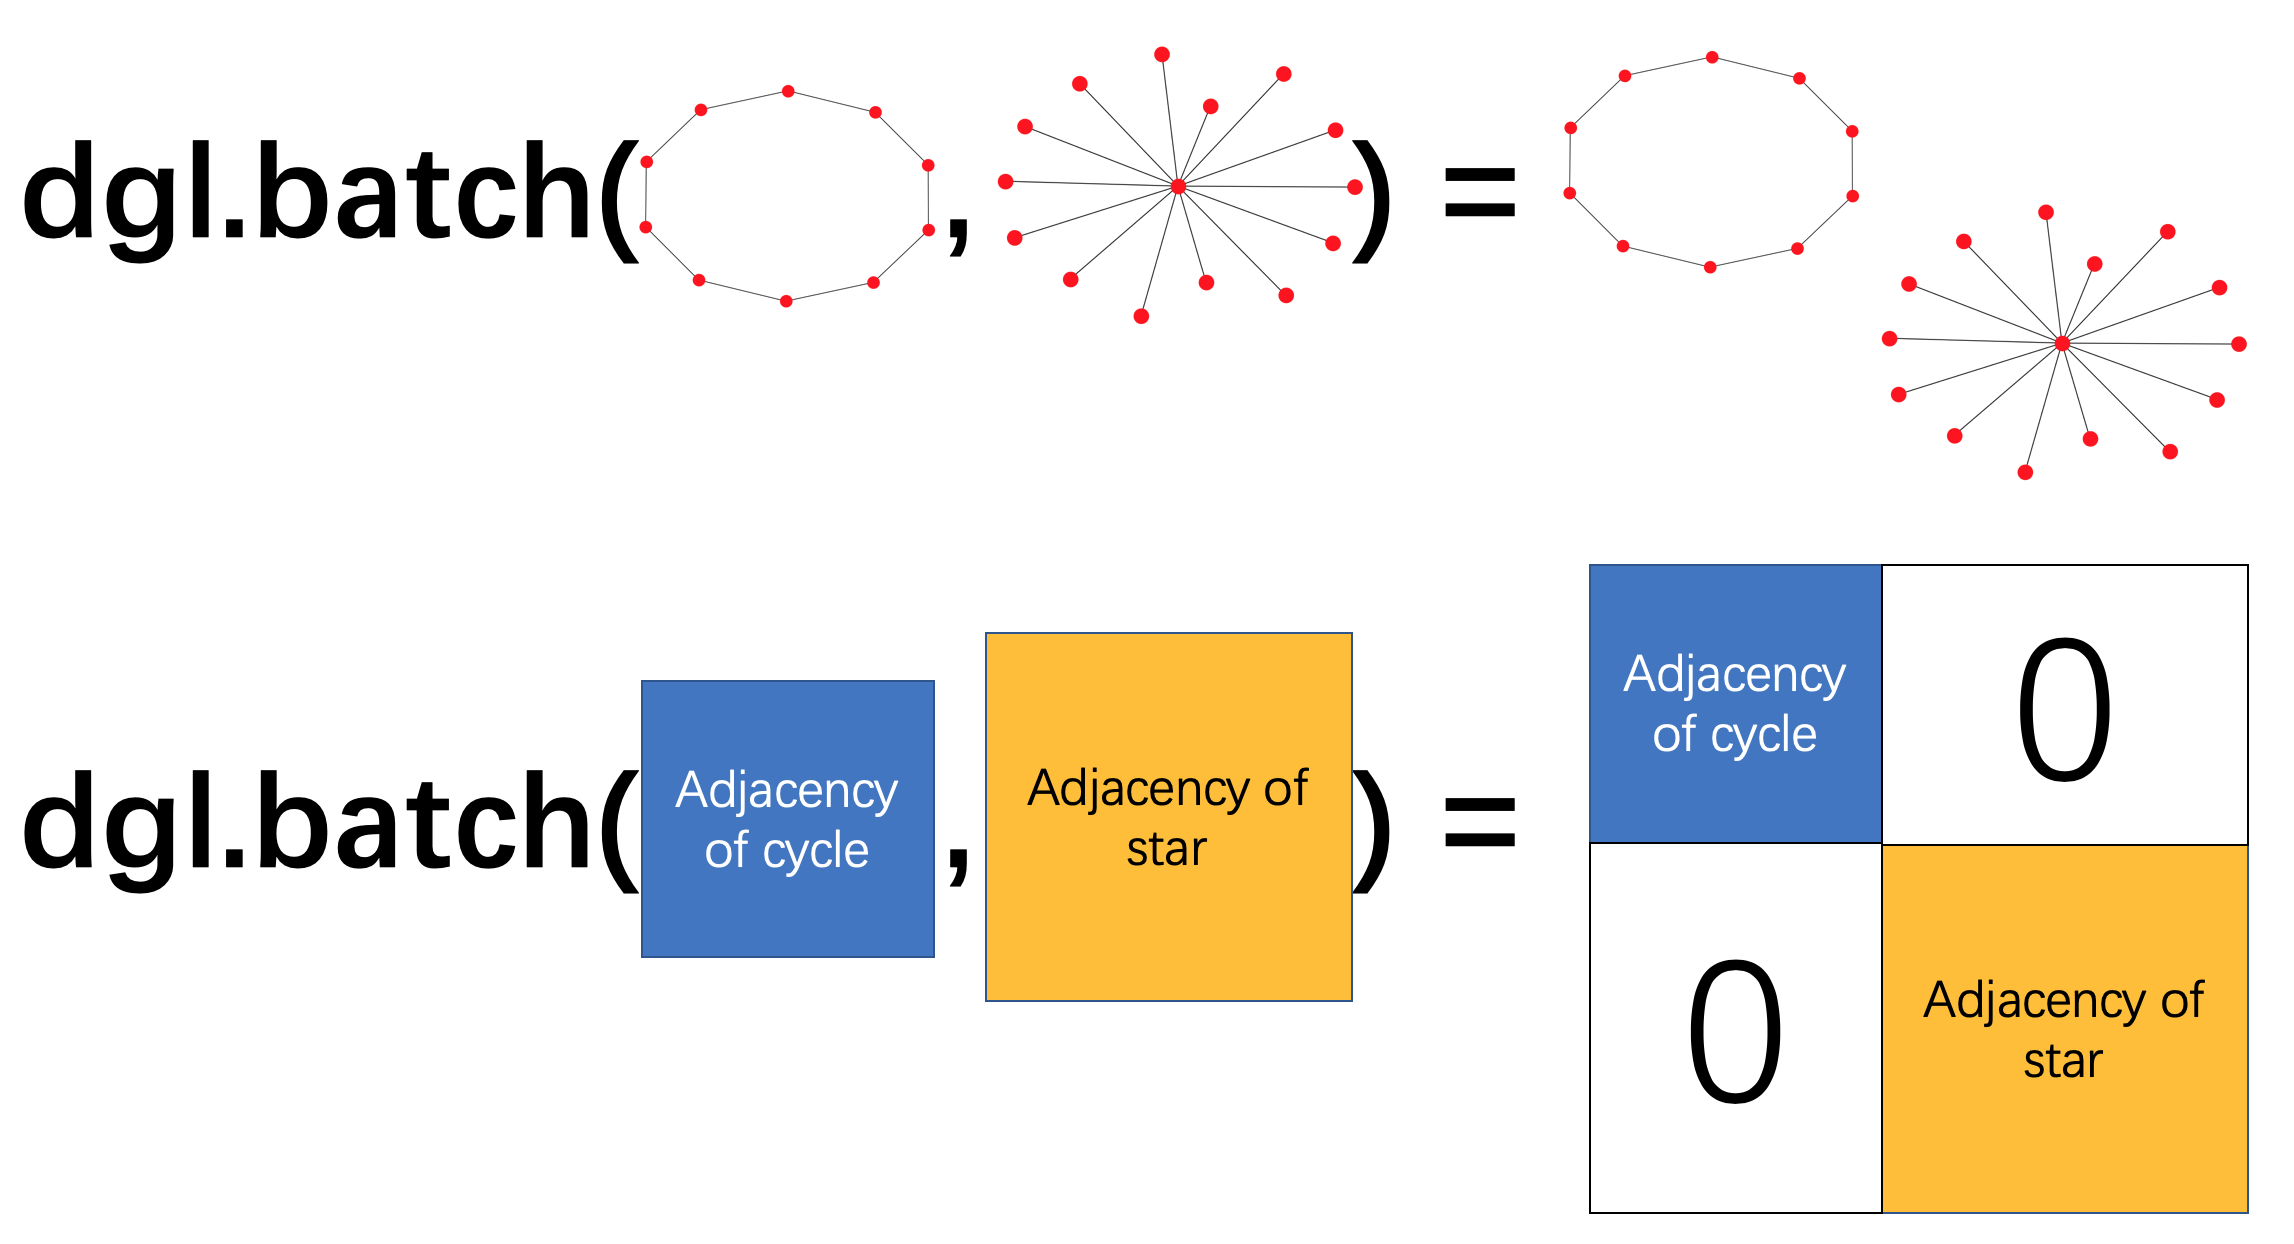

The following example calls dgl.batch() on a list of graphs. A batched graph is a single graph, while it also carries information about the list.

In [ ]:
import dgl
import torch as th

g1 = dgl.graph((th.tensor([0, 1, 2]), th.tensor([1, 2, 3])))
g2 = dgl.graph((th.tensor([0, 0, 0, 1]), th.tensor([0, 1, 2, 0])))

bg = dgl.batch([g1, g2])
bg
# Graph(num_nodes=7, num_edges=7,
#       ndata_schemes={}
#       edata_schemes={})
bg.batch_size
# 2
bg.batch_num_nodes()
# tensor([4, 3])
bg.batch_num_edges()
# tensor([3, 4])
bg.edges()
# (tensor([0, 1, 2, 4, 4, 4, 5], tensor([1, 2, 3, 4, 5, 6, 4]))

Please note that __most dgl transformation functions will discard the batch information.__ In order to maintain such information, please use dgl.DGLGraph.set_batch_num_nodes() and dgl.DGLGraph.set_batch_num_edges() on the transformed graph.

### Graph Readout

Every graph in the data may have its unique structure, as well as its node and edge features. In order to make a single prediction, one usually aggregates and summarizes over the possibly abundant information. This type of operation is named readout. Common readout operations include summation, average, maximum or minimum over all node or edge features.

Given a graph $g$,one can define the average node feature readout as
$$h_g=\frac{1}{|V|}\sum_{v\in V}h_v$$

where $h_g$ is the representation of $g$,$V$ is the set of nodes in $g$,$h_v$ is the feature of node $v$

DGL provides built-in support for common readout operations. For example, dgl.mean_nodes() implements the above readout operation.

Once $h_g$ is available, one can pass it through an MLP layer for classification output.

## Writing Neural Network Model

The input to the model is the batched graph with node and edge features.

### Computation on a Batched Graph

First, different graphs in a batch are entirely separated, i.e. no edges between any two graphs. With this nice property, all message passing functions still have the same results.

Second, the readout function on a batched graph will be conducted over each graph separately. Assuming the batch size is $B$ and feature to be aggregated has dimension $D$,the shape of the readout result will be $(B,D)$

In [2]:
import dgl
import torch

g1 = dgl.graph(([0, 1], [1, 0]))
g1.ndata['h'] = torch.tensor([2., 2.])
g2 = dgl.graph(([0, 1], [1, 2]))
g2.ndata['h'] = torch.tensor([6., 2., 3.])

print(dgl.readout_nodes(g1, 'h'))
# tensor([3.])  # 2 + 2

bg = dgl.batch([g1, g2])
print(dgl.readout_nodes(bg, 'h'))
# tensor([3., 6.])  # [2 + 2, 6 + 2 + 3]

tensor([4.])
tensor([ 4., 11.])


Finally, each node/edge feature in a batched graph is obtained by concatenating the corresponding features from all graphs in order.

In [3]:
bg.ndata['h']
# tensor([2., 2., 6., 2., 3.])

tensor([2., 2., 6., 2., 3.])

### Model Definition

Being aware of the above computation rules, one can define a model as follows.

In [ ]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'h')
            return self.classify(hg)

## Training Loop

### Data Loading

Once the model is defined, one can start training. Since graph classification deals with lots of relatively small graphs instead of a big single one, one can train efficiently on stochastic mini-batches of graphs, without the need to design sophisticated graph sampling algorithms.

In [ ]:
import dgl.data
dataset = dgl.data.GINDataset('MUTAG', False)

Each item in the graph classification dataset is a pair of a graph and its label. One can speed up the data loading process by taking advantage of the GraphDataLoader to iterate over the dataset of graphs in mini-batches.

In [ ]:
from dgl.dataloading import GraphDataLoader
dataloader = GraphDataLoader(
    dataset,
    batch_size=1024,
    drop_last=False,
    shuffle=True)

Training loop then simply involves iterating over the dataloader and updating the model.

In [ ]:
import torch.nn.functional as F

# Only an example, 7 is the input feature size
model = Classifier(7, 20, 5)
opt = torch.optim.Adam(model.parameters())
for epoch in range(20):
    for batched_graph, labels in dataloader:
        feats = batched_graph.ndata['attr']
        logits = model(batched_graph, feats)
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

## Heterogeneous graph

Graph classification with heterogeneous graphs is a little different from that with homogeneous graphs. In addition to graph convolution modules compatible with heterogeneous graphs, one also needs to aggregate over the nodes of different types in the readout function.

The following shows an example of summing up the average of node representations for each node type.

In [ ]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs is features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

class HeteroClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, rel_names):
        super().__init__()

        self.rgcn = RGCN(in_dim, hidden_dim, hidden_dim, rel_names)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        h = g.ndata['feat']
        h = self.rgcn(g, h)
        with g.local_scope():
            g.ndata['h'] = h
            # Calculate graph representation by average readout.
            hg = 0
            for ntype in g.ntypes:
                hg = hg + dgl.mean_nodes(g, 'h', ntype=ntype)
            return self.classify(hg)

# etypes is the list of edge types as strings.
model = HeteroClassifier(10, 20, 5, etypes)
opt = torch.optim.Adam(model.parameters())
for epoch in range(20):
    for batched_graph, labels in dataloader:
        logits = model(batched_graph)
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

# 5.5 Use of Edge Weights

In a weighted graph, each edge is associated with a semantically meaningful scalar weight. For example, the edge weights can be connectivity strengths or confidence scores. Naturally, one may want to utilize edge weights in model development.

## Message Passing With Edge Weights

Most graph neural networks (GNNs) integrate the graph topology information in forward computation by and only by the message passing mechanism. A message passing operation can be viewed as a function that takes an adjacency matrix and additional input features as input arguments. For an unweighted graph, the entries in the adjacency matrix can be zero or one, where a one-valued entry indicates an edge. If this graph is weighted, the non-zero entries can take arbitrary scalar values. This is equivalent to multiplying each message by its corresponding edge weight as in GAT.

With DGL, one can achieve this by:
*  Saving the edge weights as an edge feature
*  Multplying the original message by the edge feature in the message function

Consider the message passing example with DGL below.

In [ ]:
import dgl.function as fn

# Suppose graph.ndata['ft'] stores the input node features
graph.update_all(fn.copy_u('ft', 'm'), fn.sum('m', 'ft'))

# One can modify it for edge weight support as follows.

import dgl.function as fn

# Save edge weights as an edge feature, which is a tensor of shape (E, *)
# E is the number of edges
graph.edata['w'] = eweight

# Suppose graph.ndata['ft'] stores the input node features
graph.update_all(fn.u_mul_e('ft', 'w', 'm'), fn.sum('m', 'ft'))

## Using NN Modules with Edge Weights

One can modify an NN module for edge weight support by modifying all message passing operations in it. The following code snippet is an example for NN module supporting edge weights.

DGL’s built-in NN modules support edge weights if they take an optional edge_weight argument in the forward function.

One may need to normalize raw edge weights. In this regard, DGL provides EdgeWeightNorm().